# Fire Detection - MobileNet V2

**Author:** [Sayan Nath](https://github.com/sayannath/) <br>
**Date Created:** 2021/04/25 <br>
**Dataset Link:** [Kaggle Link](https://www.kaggle.com/phylake1337/fire-dataset)

## Initial Setup

In [1]:
!nvidia-smi

Fri Apr 30 21:50:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data Gathering

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

!unzip -q "/content/gdrive/My Drive/fire_dataset.zip"

Mounted at /content/gdrive


## Import the Packages

In [3]:
import tensorflow as tf
from imutils import paths
from pprint import pprint
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import mixed_precision
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt

import numpy as np

np.random.seed(42)
tf.random.set_seed(42)
print(tf.__version__)

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

2.4.1
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


## Data EDA and Parsing

In [4]:
image_paths = list(paths.list_images("fire_dataset"))
np.random.shuffle(image_paths)
image_paths[:5]

['fire_dataset/fire_images/fire359.jpg',
 'fire_dataset/fire_images/fire352.jpg',
 'fire_dataset/non_fire_images/non_fire157.jpg',
 'fire_dataset/fire_images/fire217.jpg',
 'fire_dataset/fire_images/fire395.jpg']

In [5]:
labels = []
for image_path in image_paths:
    label = image_path.split("/")[1]
    labels.append(label)
class_count = Counter(labels) 
pprint(class_count)

Counter({'fire_images': 755, 'non_fire_images': 244})


Imbalanced Dataset

## Configure the Hyperparameter

In [6]:
TRAIN_SPLIT = 0.9
IMG_SIZE = 224
BATCH_SIZE = 64
AUTO = tf.data.AUTOTUNE
EPOCHS = 100

## Splitting the dataset

In [7]:
i = int(len(image_paths) * TRAIN_SPLIT)

train_paths = image_paths[:i]
train_labels = labels[:i]
validation_paths = image_paths[i:]
validation_labels = labels[i:]

print(len(train_paths), len(validation_paths))

899 100


## Labelling the dataset

In [8]:
le = LabelEncoder()
train_labels_le = le.fit_transform(train_labels)
validation_labels_le = le.transform(validation_labels)
print(train_labels_le[:5])

[0 0 1 0 0]


## Dataloader

In [13]:
@tf.function
def load_images(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3, expand_animations = False)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return (image, label)

data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.02),
        tf.keras.layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

## Convert the data into `TensorFlow Dataset` objects

In [14]:
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels_le))
train_ds = (
    train_ds
    .shuffle(1024)
    .map(load_images, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

val_ds = tf.data.Dataset.from_tensor_slices((validation_paths, validation_labels_le))
val_ds = (
    val_ds
    .map(load_images, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

## Calculate the Classweights

In [15]:
trainLabels = to_categorical(train_labels_le)
classTotals = trainLabels.sum(axis=0)
classWeight = dict()
# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
	classWeight[i] = classTotals.max() / classTotals[i]

## Define the Model

In [16]:
def get_training_model(trainable=False):
    # Load the MobileNetV2 model but exclude the classification layers
    EXTRACTOR = MobileNetV2(weights="imagenet", include_top=False,
                    input_shape=(224, 224, 3))
    # We will set it to both True and False
    EXTRACTOR.trainable = trainable
    # Construct the head of the model that will be placed on top of the
    # the base model
    class_head = EXTRACTOR.output
    class_head = GlobalAveragePooling2D()(class_head)
    class_head = Dense(256, activation="relu")(class_head)
    class_head = Dropout(0.5)(class_head)
    class_head = Dense(1, activation="sigmoid")(class_head)

    # Create the new model
    classifier = tf.keras.Model(inputs=EXTRACTOR.input, outputs=class_head)

    # Compile and return the model
    classifier.compile(loss="binary_crossentropy", 
                          optimizer="adam",
                          metrics=["accuracy"])

    return classifier

## Plot the Model Performance

In [17]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Training Progress")
    plt.ylabel("Accuracy/Loss")
    plt.xlabel("Epochs")
    plt.legend(["train_acc", "val_acc", "train_loss", "val_loss"], loc="upper left")
    plt.show()

## Setting the callback

In [18]:
train_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

## Train the `model`

9412608/9406464 [==============================] - 0s 0us/step
Epoch 1/100
15/15 [==============================] - 52s 1s/step - loss: 1.2931 - accuracy: 0.6861 - val_loss: 0.1589 - val_accuracy: 0.9400
Epoch 2/100
15/15 [==============================] - 27s 2s/step - loss: 0.2647 - accuracy: 0.9256 - val_loss: 0.1222 - val_accuracy: 0.9600
Epoch 3/100
15/15 [==============================] - 27s 2s/step - loss: 0.2546 - accuracy: 0.9372 - val_loss: 0.1047 - val_accuracy: 0.9800
Epoch 4/100
15/15 [==============================] - 27s 2s/step - loss: 0.1320 - accuracy: 0.9778 - val_loss: 0.1034 - val_accuracy: 0.9800
Epoch 5/100
15/15 [==============================] - 27s 2s/step - loss: 0.1267 - accuracy: 0.9747 - val_loss: 0.1070 - val_accuracy: 0.9700
Epoch 6/100
15/15 [==============================] - 28s 2s/step - loss: 0.1216 - accuracy: 0.9811 - val_loss: 0.1101 - val_accuracy: 0.9700
Epoch 7/100
15/15 [==============================] - 27s 2s/step - loss: 0.0919 - accuracy:

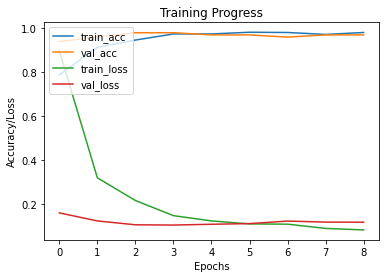

In [19]:
classifier = get_training_model()
h = classifier.fit(train_ds,
               validation_data=val_ds,
               epochs=EPOCHS,
               class_weight=classWeight,
               callbacks=train_callbacks)

accuracy = classifier.evaluate(val_ds)[1] * 100
print("Accuracy: {:.2f}%".format(accuracy))
plot_hist(h)

## Saving the Model

In [20]:
classifier.save('mobilenet_v2_fire')
classifier.save('mobilenet_v2_fire.h5')

INFO:tensorflow:Assets written to: mobilenet_v2_fire/assets


In [1]:
!du -lh mobilenet_v2_fire

4.0K	mobilenet_v2_fire/assets
13M	mobilenet_v2_fire/variables
16M	mobilenet_v2_fire


In [2]:
!tar cvf mobilenet_v2_fire.tar.gz mobilenet_v2_fire mobilenet_v2_fire.h5

mobilenet_v2_fire/
mobilenet_v2_fire/saved_model.pb
mobilenet_v2_fire/assets/
mobilenet_v2_fire/variables/
mobilenet_v2_fire/variables/variables.data-00000-of-00001
mobilenet_v2_fire/variables/variables.index
mobilenet_v2_fire.h5
